# Chapter 6 - Linear Model Inference

Joshua French

To open this information in an interactive Colab notebook, click or scan the QR code below.

<a href="https://colab.research.google.com/github/jfrench/LinearRegression/blob/master/notebooks/06-linear-model-inference-notebook.ipynb"> <img src="https://raw.githubusercontent.com/jfrench/LinearRegression/68b90703718e3dc214dedfa7b0c22b6604c29327/images/qr-inference.svg"> </a>

------------------------------------------------------------------------

In [ ]:
if(!require(palmerpenguins, quietly = TRUE)) {
  install.packages("palmerpenguins", repos = "https://cran.rstudio.com/")
  library(palmerpenguins)
}
if(!require(api2lm, quietly = TRUE)) {
  install.packages("api2lm", repos = "https://cran.rstudio.com/")
  library(api2lm)
}

We adjust some printing options for clarity.

In [ ]:
options(digits = 7, scipen = 2)

# Overview of inference and prediction

------------------------------------------------------------------------

Inference and prediction are often intertwined, so we discuss them together.

*Inference* focuses on drawing conclusions about the data-generating distribution

-   The two primary types of statistical inference are confidence intervals and hypothesis tests.
-   The Estimation & Inference Appendix provides an overview of both confidence intervals and hypothesis tests in a more general context.

*Prediction* focuses on selecting a plausible value or range of values for an unobserved response.

-   Prediction often makes use of estimated parameters we find as part of the inferential process, though this isn’t required.

We will also introduce and discuss solutions for the multiple comparisons problem, which arises when we make multiple inferences or predictions simultaneously.

# Some relevant distributions

------------------------------------------------------------------------

The $t$ distribution is a symmetric bell-shaped distribution like the normal distribution but has a larger standard deviation.

-   The $t$ distribution has a degrees of freedom parameter, $\nu$.
-   $t_{\nu}$ denotes a random variable having a $t$ distribution with $\nu$ degrees of freedom.
    -   As the degrees of freedom of a $t$ random variable increases it behaves more and more similarly to a random variable with a standard normal distribution (a $\mathsf{N}(0,1)$ distribution).
-   $t_{\nu}^{\alpha}$ denotes the $1-\alpha$ quantile of a $t$ distribution with $\nu$ degrees of freedom.

The figure below displays the density of a $t$ distribution with 10 degrees of freedom while also indicating the 0.95 quantile of that distribution.

-   Additional information about the $t$ distribution is available on [Wikipedia](https://en.wikipedia.org/wiki/Student%27s_t-distribution).

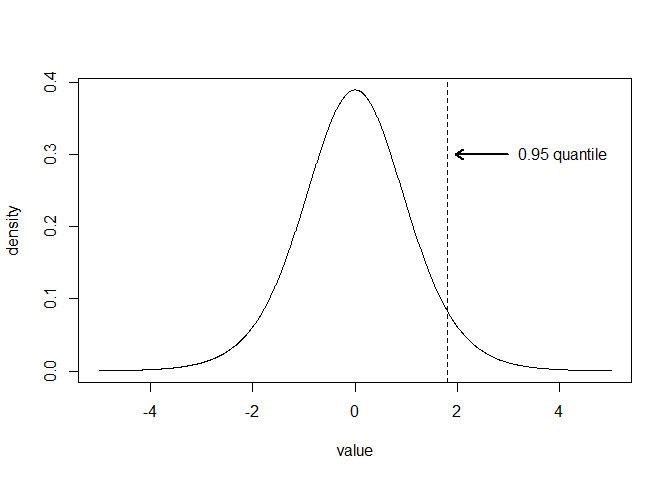

The $F$ distribution is characterized as the ratio of two independent chi-square random variables divided by their degrees of freedom.

-   It has a numerator degrees of freedom parameter, $\nu_1$, and a denominator degrees of freedom parameter, $\nu_2$.
-   The notation $F_{\nu_1, \nu_2}$ denotes a random variable having an $F$ distribution with $\nu_1$ numerator degrees of freedom and $\nu_2$ denominator degrees of freedom.
-   $F^{\alpha}_{\nu_1,\nu_2}$ denotes the $1-\alpha$ quantile of an $F$ random variables with $\nu_1$ numerator degrees of freedom and $\nu_2$ denominator degrees of freedom.
-   In fact, $[t_{\nu}]^2=F_{1,\nu}$, i.e., the square of a $t$ random variable with $\nu$ degrees of freedom is equivalent to an $F$ random variable with $1$ numerator degree of freedom and $\nu$ denominator degrees of freedom.

# Assumptions and properties of the OLS estimator

------------------------------------------------------------------------

We assume:

-   $\mathbf{y} = \mathbf{X}\boldsymbol{\beta}+\boldsymbol{\epsilon}$.

-   $\boldsymbol{\epsilon}\mid \mathbf{X}\sim \mathsf{N}(\mathbf{0}_{n\times 1},\sigma^2 \mathbf{I}_{n\times n})$.

This assumption applies to all errors, so we believe that all errors, observed and future, will have mean 0, variance $\sigma^2$, will be uncorrelated with other observations, and have a normal distribution.

Under these assumptions, we have already shown that

-   $\mathbf{y}\mid \mathbf{X}\sim \mathsf{N}(\mathbf{X}\boldsymbol{\beta}, \sigma^2 \mathbf{I}_{n\times n})$.
-   $\hat{\boldsymbol{\beta}}\mid \mathbf{X} \sim \mathsf{N}(\boldsymbol{\beta}, \sigma^2(\mathbf{X}^T\mathbf{X})^{-1})$.

# Parametric confidence intervals for regression coefficients

## Standard $t$-based confidence intervals\*\*

Under the assumptions above, we can prove (though we won’t) that

$$
\frac{\hat{\beta}_j-\beta_j}{\hat{\mathrm{se}}(\hat{\beta}_j)}\sim t_{n-p}, \quad j=0,1,\ldots,p-1,
$$

where the estimated standard error of $\hat{\beta}_j$ is

$$
\hat{\mathrm{se}}(\hat{\beta}_j)=\hat{\sigma}\sqrt{(\mathbf{X}^T\mathbf{X})^{-1}_{j+1,j+1}}.
$$

Recall that:

-   Estimated standard error is the estimated standard deviation of the sampling distribution of $\hat{\beta}_j$.
-   The notation $(\mathbf{X}^T\mathbf{X})^{-1}_{j+1,j+1}$ indicates the element in row $j+1$, column $j+1$, of the matrix $(\mathbf{X}^T\mathbf{X})^{-1}$.

$(\hat{\beta}_j-\beta_j)/\hat{\mathrm{se}}(\hat{\beta}_j)$ is a pivotal quantity with a $t$ distribution, and it can be used to derive a confidence interval.

A confidence interval for $\beta_j$ with confidence level $1-\alpha$ is given by the expression:

$$
\hat{\beta}_j \pm t^{\alpha/2}_{n-p} \hat{\mathrm{se}}(\hat{\beta}_j),\quad j=0,1,\ldots,p-1.
$$

It is critical to note that the $1-\alpha$ confidence level refers to the procedure for a single interval. The confidence level for a procedure producing a family of intervals will be less than $1-\alpha$ without proper adjustment.

The `confint` function returns confidence intervals for the regression coefficients of a fitted model.

The `confint` function has 3 main arguments:

-   `object`: a fitted model (`lm`) object.
-   `parm`: a vector of numbers or names indicating the parameters for which we want to construct confidence intervals.
    -   By default, confidence intervals are constructed for all parameters.
-   `level`: the confidence level desired for the confidence interval.
    -   The default value is `0.95`, which will produce 95% confidence intervals.

We once again use the `penguins` data from the **palmerpenguins** package to illustrate what we have learned.

## Penguins example

Consider the regression model:

$$
\begin{aligned}
&E(\mathtt{bill\_length\_mm}\mid \mathtt{body\_mass\_g}, \mathtt{flipper\_length\_mm}) \\
&=\beta_0+\beta_1 \mathtt{body\_mass\_g} + \beta_2 \mathtt{flipper\_length\_mm}.
\end{aligned}
$$

We estimate the parameters of this model in R.

In [ ]:
# load data
data(penguins, package = "palmerpenguins")
# fit model
mlmod <- lm(bill_length_mm ~ body_mass_g + flipper_length_mm, data = penguins)

We obtain the 95% confidence intervals for the 3 regression coefficients.

In [ ]:
confint(mlmod)

The 95% confidence interval for the intercept parameter is \[-12.45, 5.58\]. We are 95% confident that the mean penguin bill length is between -12.25 and 5.58 mm for a penguin with a body mass of 0 g and a flipper length of 0 mm. (This really isn’t sensible).

The 95% confidence interval for the `body_mass_g` coefficient is \[-0.00046, 0.002\]. We are 95% confident the regression coefficient for `body_mass_g` is between -0.00046 and 0.002, assuming the `flipper_length_mm` regressor is also in the model.

If we wanted to get the 90% confidence interval for the `flipper_length_mm` coefficient by itself, we could use either of the commands shown below.

In [ ]:
confint(mlmod, parm = 3, level = 0.90)

In [ ]:
confint(mlmod, parm = "flipper_length_mm", level = 0.90)

# The multiple comparisons problem

Our linear models typically have multiple regression coefficients.

-   We typically want to construct confidence intervals for all of the coefficients.

The confidence level of the procedure described in the previous section is only valid for a single interval.

Since we are constructing multiple intervals, the simultaneous confidence level of the procedure for the family of intervals is less than $1-\alpha$.

This is an example of the multiple comparisons problem.

A **multiple comparisons problem** occurs anytime we make multiple inferences (confidence intervals, hypothesis tests, prediction intervals, etc.).

-   If we construct two confidence intervals with level 0.95, then the probability that both intervals simultaneously contain their respective target parameters will be less than 0.95.
-   We can guarantee that our family-wise confidence level will be at least 0.90, but we can’t determine the exact value without more information
-   We are more likely to draw erroneous conclusions if we do not adjust for the fact that we are making multiple inferential statements.

The **family-wise confidence level** is the probability that a confidence interval procedure produces a family of intervals that simultaneously contain their target parameter.

-   The family-wise confidence level is also known as the **simultaneous** or **overall** confidence level.

A **multiple comparisons procedure** is a procedure designed to adjust for multiple inferences.

-   E.g., a multiple comparisons procedure will produce a family of intervals that have a family-wise confidence level above some threshold.

## Adjusted confidence intervals for regression coefficients

Bonferroni (1936) proposed a simple multiple comparisons procedure that is applicable in many contexts. This general procedure is known as the **Bonferroni correction**.

Suppose we are constructing $k$ confidence intervals simultaneously. We control the family-wise confidence level of our intervals at $1-\alpha$ if we construct the individual confidence intervals with the level $1-\alpha/k$. We sketch a proof of this below.

Boole’s inequality (Boole 1847) states that for a countable set of events $A_1, A_2, A_3 \ldots$,

$$P(\cup_{j=1}^\infty A_j) \leq \sum_{j=1}^\infty P(A_j).$$

This is a generalization of the fact that

$$
P(A \cup B) = P(A) + P(B) - P(A\cap B) \leq P(A) + P(B).
$$

for two events $A$ and $B$.

Suppose that we construct a family of $k$ confidence intervals with individual confidence level $1-\alpha/k$ (and all assumptions are satisfied.)

-   The probability that the confidence interval procedure for a specific interval doesn’t produce an interval containing the target parameter is $\alpha/k$.

Then:

$$
\begin{aligned}
& P(\mbox{All }k\mbox{ intervals contain the target parameter}) \\
& = 1 - P(\mbox{At least one of the }k\mbox{ intervals misses the target parameter}) \\
& = 1 - P(\cup_{j=1}^k \mbox{interval }j\mbox{ misses the target parameter}) \\
& \geq 1 - \sum_{j=1}^k P(\mbox{interval }j\mbox{ misses the target parameter}) \\
& = 1 - k(\alpha/k) \\
&= 1-\alpha.
\end{aligned}
$$

Thus, the family-wise confidence level of all $k$ intervals is AT LEAST $1-\alpha$ when the Bonferroni correction is used.

The Bonferroni correction is known to be conservative, which means that the family-wise confidence level is typically much larger than $1-\alpha$.

-   Conservative methods can have low power.
-   i.e., Our intervals are much wider than they need to be, so we aren’t able to draw precise conclusions about the plausible values of our regression coefficients.

## Penguins example (continued)

Let’s construct simultaneous confidence intervals for our `penguins` example using the Bonferroni correction.

If we want to control the family-wise confidence level of our $k=3$ intervals at $0.95$, then $\alpha = 0.05$ and the Bonferroni correction suggests that we should construct the individual intervals at a confidence level of $1-0.05/3=0.983$.

We construct the Bonferroni-adjusted confidence intervals using the code below.

In [ ]:
# Simultaneous 95% confidence intervals for mlmod
confint(mlmod, level = 1 - 0.05/3)

The `confint_adjust` function works almost identically to the `confint` function.

-   The `confint_adjust` function takes a `method` argument to indicate the type of adjustment to make when constructing the confidence intervals.
-   e.g., `method = "bonferroni"` will produce Bonferroni-corrected intervals.

In [ ]:
confint_adjust(mlmod, method = "bonferroni")

Working and Hotelling (1929) developed another multiple comparisons procedure that can be used to preserve the family-wise confidence level of the intervals at $1-\alpha$.

The Working-Hotelling multiple comparisons procedure is valid for ALL linear combinations of the regression coefficients, meaning that we can construct an arbitrarily large number of confidence intervals for linear combinations of the regression coefficients with this procedure and the family-wise confidence level will be at least $1-\alpha$ (Weisberg 2014).

The Working-Hotelling procedure guarantees that if we construct the individual confidence intervals in the following way, then the family-wise confidence level will be at least $1-\alpha$:

$$
\hat{\beta}_j \pm \sqrt{p F^\alpha_{p,n-p}} \hat{\mathrm{se}}(\hat{\beta}_j),\quad j=0,1,\ldots,p-1.
$$

The `confint_adjust` function from the **api2lm** package will produce these intervals when setting the `method` argument to `"wh"`. We construct Working-Hotelling-adjusted intervals with family-wise confidence level of at least 0.95 for the `penguins` example using the code below.

In [ ]:
confint_adjust(mlmod, method = "wh")

In this example, the Bonferroni-adjusted intervals are narrower than the Working-Hotelling-adjusted intervals.

The Working-Hotelling intervals tends to be narrower for small $p$ (e.g., $p=1$ or $2$) and small $n-p$ (e.g., $n-p = 1$ or $2$) (Mi and Sampson 1993).

As the number of intervals increases, the Working-Hotelling intervals will eventually be narrower than the Bonferroni-adjusted intervals.

# Prediction: mean response versus new response

It is common to make two types of predictions in a regression context:

-   Prediction of a mean response.
-   Prediction of a new response.

In either context, we want to make predictions with respect to a specific combination of regressor values, which we denote $\mathbf{x}_0=[1,x_{0,1},\ldots,x_{0,p-1}]$.

The mean response for a specific combination of regressors is denoted $E(Y\mid \mathbb{X}=\mathbf{x}_0)$.

We use the notation $Y(\mathbf{x}_0)$ to describe a new response for a specific combination of regressor values, $\mathbb{X}=\mathbf{x}_0$.

$E(Y\mid \mathbb{X}=\mathbf{x}_0)$ represents the average response when the regressor values are $\mathbf{x}_0$.

-   i.e., the number we would get if were able to determine the average of an infinite number of responses with regressor values being fixed at $\mathbf{x}_0$.

$Y(\mathbf{x}_0)$ represents the actual response we will observe for a new observation with regressor values $\mathbf{x}_0$.

-   Mathematically, $Y(\mathbf{x}_0)=E(Y\mid \mathbb{X}=\mathbf{x}_0)+\epsilon(\mathbf{x}_0)$, where $\epsilon(\mathbf{x_0})$ denotes the error for our new observation.
-   Thus, $Y(\mathbf{x}_0)$ represents the mean response for that combination of regressor values plus some error.

**Example**

Suppose we want to rent a new apartment or buy a new house. If we look through the available listings, we will likely filter our search results by certain characteristics. We might limit our search to dwellings with 3 bedrooms, 2 bathrooms, that are within a certain distance of public transportation, and have a certain amount of square footage.

-   If we averaged the monthly rent or asking price of all the dwellings matching our specifications, then that would be an approximation of the mean response for that combination of specifications (i.e., regressors).
    -   We would need all the possible dwellings matching those characteristics to get the true mean.
    -   This average would give us an idea of the “typical” price of dwellings with those characteristics.
-   On the other hand, we likely want to know the price of the dwelling we actually end up in. This is the “new response” we want to predict.

It is common to distinguish the two scenarios by using the terminology:

-   “Estimating the mean response” to refer to prediction of the the mean.
-   “Prediction a new response” when we want to predict a new observation.

# Confidence interval for the mean response

Consider a typical linear regression model with $p$ regression coefficients given by:

$$
E(Y|\mathbb{X})=\beta_0+\beta_1 X_1 + \ldots \beta_{p-1} X_{p-1}.
$$

To estimate the mean response for a specific combination of regressor values, $\mathbf{x}_0=[1,x_{0,1},\ldots,x_{0,p-1}]$, we can use either of the following equations:

$$
\begin{aligned}
E(Y\mid \mathbb{X}=\mathbf{x}_0) &= \beta_0 + \sum_{j=1}^{p-1}x_{0,j}\beta_j \\
&= \mathbf{x}_0^T \boldsymbol{\beta}.
\end{aligned}
$$

To simplify our notation, we drop the “$\mathbb{X}=$” in our discussion below, so $E(Y\mid \mathbb{X}=\mathbf{x}_0)\equiv E(Y\mid \mathbf{x}_0)$.

$E(Y\mid \mathbf{x}_0)$ represents the average response we will observe if we somehow managed to observe infinitely many responses with $\mathbb{X}=\mathbf{x}_0$.

The Gauss-Markov Theorem discussed before indicates that the best linear unbiased estimator of the mean response is given by the equation:

$$
\begin{aligned}
\hat{E}(Y\mid \mathbf{x}_0) &= \hat{\beta}_0 + \sum_{j=1}^{p-1}x_{0,j}\hat{\beta}_j \\
&= \mathbf{x}_0^T \hat{\boldsymbol{\beta}},
\end{aligned}
$$

which replaces the unknown, true coefficients by their OLS estimates.

We want to create a confidence interval for $E(Y\mid \mathbf{x}_0)$.

We can use the pivotal quantity

$$
\frac{E(Y\mid \mathbf{x}_0)-\hat{E}(Y\mid \mathbf{x}_0)}{\sqrt{\hat{\mathrm{var}}\left(E(Y\mid \mathbf{x}_0)-\hat{E}(Y\mid \mathbf{x}_0)\right)}} = \frac{E(Y\mid \mathbf{x}_0)- \mathbf{x}_0^T \hat{\boldsymbol{\beta}}}{ \hat{\mathrm{se}}(\mathbf{x}_0^T\hat{\boldsymbol{\beta}})}\sim t_{n-p}.
$$

The denominator is

$$
\hat{\mathrm{se}}(\mathbf{x}_0^T\hat{\boldsymbol{\beta}})=\hat{\sigma}\sqrt{\mathbf{x}_0^T (\mathbf{X}^T \mathbf{X})^{-1}\mathbf{x}_0}.
$$

A confidence interval for $E(Y\mid \mathbf{x}_0)$ with confidence level $1-\alpha$ is given by the expression:

$$
\mathbf{x}_0^T\hat{\boldsymbol{\beta}} \pm t^{\alpha/2}_{n-p} \hat{\mathrm{se}}(\mathbf{x}_0^T\hat{\boldsymbol{\beta}}).
$$

The `predict` method for an `lm` object can be used to:

-   Estimate the mean response for multiple combinations of predictor variables.
-   Compute the estimated standard error of each estimate.
-   Obtain confidence intervals for the mean response.

The primary arguments to the `lm` method for `predict` are:

-   `object`: A fitted model from the `lm` function.
-   `newdata`: A data frame of predictor values. All predictors used in the formula used to fit `object` must be provided.
    -   Each row contains the predictor values for the mean response we want to estimate.
    -   If this is not provided, then the fitted values for each observation are returned.
-   `se.fit`: A logical value indicating whether we want to explicitly compute the standard errors of each estimated mean, i.e., $\hat{\mathrm{se}}(\mathbf{x}_0^T \hat{\boldsymbol{\beta}})$ for each estimate.
-   `interval`: The type of interval to compute.
    -   The default is `"none"`, meaning no interval is provided.
    -   Setting `interval = "confidence"` will return a confidence interval for the mean response associated with each row of `newdata`.
    -   Setting `interval = "prediction"` will return a prediction interval for a new response, which we will discuss in the next section.
-   `level`: The confidence level of the interval.

Run `?predict.lm` in the Console for additional details about this function.

We will estimate the mean response for the parallel lines model previously fit to the `penguins` data.

-   This is to emphasize that the `predict` function asks us to specify the values of the *predictor* variables for each estimate we want to make, not the complete set of regressors.

Recall we fit a parallel lines model to the `penguins` data that used both `body_mass_g` and `species` to explain the behavior of `bill_length_mm`. Letting $D_C$ denote the indicator variable for the `Chinstrap` level and $D_G$ denote the indicator variable for the `Gentoo` level, the fitted parallel lines model was:

$$
\begin{aligned}
&\hat{E}(\mathtt{bill\_length\_mm} \mid \mathtt{body\_mass\_g}, \mathtt{species})\\
&= 24.92 + 0.004 \mathtt{body\_mass\_g} + 9.92 D_C + 3.56 D_G.
\end{aligned}
$$

We fit this model below, assigning it the name `lmodp`.

In [ ]:
# fit parallel lines model to penguins data
lmodp <- lm(bill_length_mm ~ body_mass_g + species, data = penguins)
coef(lmodp)

Let’s estimate the mean response for the “typical” `body_mass_g` of each `species`.

-   We use the `group_by` and `summarize` functions from the **dplyr** package to simplify this process.

In [ ]:
# mean body_mass_g of each species
newpenguins <- penguins |>
  dplyr::group_by(species) |>
  dplyr::summarize(body_mass_g = mean(body_mass_g, na.rm = TRUE))
newpenguins

In the code below, we:

-   Estimate the mean `bill_length_mm` based on the fitted model in `lmodp` for the mean `body_mass_g` of each level of `species`.
-   Compute the estimated standard errors of each estimate by setting the `se.fit` argument to `TRUE`.

In [ ]:
predict(lmodp, newdata = newpenguins, se.fit = TRUE)

An Adelie penguin with a body mass of 3700.662 g is estimated to have a mean bill length of 38.79 mm with an estimated standard error of 0.196 mm.

A Chinstrap penguin with a body mass of 3733.09 g is estimated to have a mean bill length of 48.83 mm with an estimated standard error of 0.29 mm.

A Gentoo penguin with a body mass of 5076.02 g is estimated to have a mean bill length of 47.50 mm with an estimated standard error of 0.22 mm.

To compute the 98% confidence intervals of the mean response for each combination of predictors, we specify `level = 0.98` and `interval = "confidence"` in the `predict` function in the code below.

In [ ]:
predict(lmodp, newdata = newpenguins, level = 0.98, interval = "confidence")

The 98% confidence interval for the mean bill length of an Adelie penguin with a body mass of 3700.662 g is \[38.33, 39.25\] mm. We are 98% confident that the mean bill length of Adelie penguins with a body mass of 3700.662 g is between 38.33 and 39.25 mm. Note: we are constructing a confidence interval for the mean bill length of ALL Adelie penguins with this body mass, i.e., for:

$$
E(\mathtt{bill\_length\_mm}\mid \mathtt{body\_mass\_g} = 3700.662, \mathtt{species} = \mathtt{Adelie}),
$$

which is an unknown characteristic of the population of all Adelie penguins.

Similarly, the 98% confidence interval for the mean bill length of Chinstrap penguins with a body mass of 3733.09 g is \[48.15, 49.52\] mm.

Lastly, the mean bill length of Gentoo penguins with a body mass of 5076.02 g is \[46.99, 48.02\] mm, with 98% confidence.

We are once again faced with a multiple comparisons problem because we are making 3 inferences. To control the family-wise confidence level of our intervals, we can use the Bonferroni or Working-Hotelling corrections previously discussed.

Both corrections are implemented in the `predict_adjust` function in the **api2lm** package, which is intended to work identically to the `predict` function, but produces intervals that adjust for multiple comparisons.

-   The only additional argument is `method`, with choices `"none"` (no correction), `"bonferroni"` (Bonferroni adjustment), or `"wh"` (Working-Hotelling adjustment).

We produce both types of adjusted intervals in the code below.

The Bonferroni-adjusted confidence intervals are slightly narrower in this example.

In [ ]:
predict_adjust(lmodp, newdata = newpenguins,
               level = 0.98,
               interval = "confidence",
               method = "bonferroni")

In [ ]:
predict_adjust(lmodp, newdata = newpenguins,
               level = 0.98,
               interval = "confidence",
               method = "wh")

# Prediction interval for a new response

We once again assume the regression model:

$$
E(Y|\mathbb{X})=\beta_0+\beta_1 X_1 + \ldots \beta_{p-1} X_{p-1}.
$$

We want to predict a new response for a specific combination of regressor values, $\mathbf{x}_0=[1,x_{0,1},\ldots,x_{0,p-1}]$.

The new response can be written as

$$
Y(\mathbf{x}_0)=E(Y\mid \mathbf{x}_0) + \epsilon(\mathbf{x}_0).
$$

Thus, our predicted new response, $\hat{Y}(\mathbf{x})$ is the sum of two components:

-   The estimated mean.
-   The estimated error.

$$
\hat{Y}(\mathbf{x}_0)=\hat{E}(Y\mid \mathbf{x}_0) + \hat{\epsilon}(\mathbf{x}_0).
$$

The Best Linear Unbiased Predictor of $Y(\mathbf{x}_0)$ is computed as

$$
\begin{aligned}
\hat{Y}(\mathbf{x}_0) &=\hat{E}(Y\mid \mathbf{x}_0) + \hat{\epsilon}(\mathbf{x}_0)\\
&= \mathbf{x}_0^T\hat{\boldsymbol{\beta}} + 0 \\
&= \mathbf{x}_0^T\hat{\boldsymbol{\beta}}.
\end{aligned}
$$

This is the best prediction because:

-   $\hat{E}(Y\mid \mathbf{x}_0)=\mathbf{x}_0^T\hat{\boldsymbol{\beta}}$ is the best linear unbiased estimator of $E(Y\mid \mathbf{x}_0)$ according to the Gauss-Markov theorem.
-   Our best guess for the error, $\epsilon(\mathbf{x}_0)$ is zero because the errors are normally distributed with mean 0 and the errors are uncorrelated.

We want to create a prediction interval for $Y(\mathbf{x}_0)$.

-   A prediction interval is similar to a confidence interval, but the interval estimator is for a random variable ($Y(\mathbf{x}_0)$) instead of a parameter ($E(Y\mid \mathbf{x}_0)$).

We can use the $t$-distributed pivotal quantity:

$$
\frac{Y(\mathbf{x}_0)-\hat{Y}(\mathbf{x}_0)}{\widehat{\mathrm{sd}}(Y(\mathbf{x}_0)-\hat{Y}(\mathbf{x}_0))} \sim t_{n-p},
$$

where

$$
\widehat{\mathrm{sd}}(Y(\mathbf{x}_0)-\hat{Y}(\mathbf{x}_0))=\hat{\sigma}\sqrt{1 + \mathbf{x}_0^T (\mathbf{X}^T \mathbf{X})^{-1}\mathbf{x}_0}.
$$

The standard deviation of the prediction error is sometimes known as the **standard error of prediction**, but we do not use that terminology.

A prediction interval for $Y(\mathbf{x}_0)$ with confidence level $1-\alpha$ is given by the expression

$$
\mathbf{x}_0\hat{\boldsymbol{\beta}} \pm t^{\alpha/2}_{n-p} \hat{\mathrm{sd}}(Y(\mathbf{x}_0)-\hat{Y}(\mathbf{x}_0)).
$$

Comparing $\hat{\mathrm{se}}(\mathbf{x}_0^T\hat{\boldsymbol{\beta}})$ and $\widehat{\mathrm{sd}}(Y(\mathbf{x}_0)-\hat{Y}(\mathbf{x}_0))$, we notice that

$$
\hat{\mathrm{sd}}(Y(\mathbf{x}_0)-\hat{Y}(\mathbf{x}_0)) = \hat{\sigma} + \hat{\mathrm{se}}(\mathbf{x}_0^T\hat{\boldsymbol{\beta}}).
$$

*Prediction intervals for a new response are always wider than a confidence interval for the mean response* when considering the same regressor values, $\mathbf{x}_0$, and confidence level.

Conceptually, prediction intervals are wider because there are two sources of uncertainty in our prediction:

-   Estimating the mean response.
-   Predicting the error of the new response.

Estimating the mean response does not require us to predict the error of a new response, so the uncertainty of our estimate is less than predicting a new response.

The `predict` function can be used to create predictions and prediction intervals for a new response in the same way that it can be used to estimate the mean response and produce associated confidence intervals.

-   If the `interval` argument is `"none"`, then predictions for a new response are returned.
-   If the `interval` argument is `"prediction"`, then the predicted new response and associated prediction interval will be produced for each row of data supplied to the `newdata` argument.

Continuing the example from before, we want to predict the response value for new, unobserved penguins having the observed mean `body_mass_g` for each level of `species`.

In the code below, we predict the `bill_length_mm` for new penguins for the predictor values stored in `newpenguins` based on the fitted model in `lmodp`. We also construct the associated 99% prediction intervals.

In [ ]:
predict(lmodp, newdata = newpenguins, interval = "prediction", level = 0.99)

A new Adelie penguin with a body mass of 3700.662 g is predicted to have a bill length of 38.79 mm. We are 99% confident that a new Adelie penguin with a body mass of 3700.662 g will have a bill length between 32.54 mm and 45.04 mm.

Similarly, the 99% prediction interval for the bill length of a new Chinstrap penguin with a body mass of 3733.09 g is \[48.56, 55.11\] mm.

The bill length of a new Gentoo penguin with a body mass of 5076.02 g is between 41.25 and 53.76 mm with a confidence level of 0.99.

Since we are making 3 predictions, our inferences suffer from the multiple comparisons problem.

To control the family-wise confidence level of our intervals, we can use the Bonferroni correction with $k=3$.

The Working-Hotelling correction does not apply to new responses. A similar adjustment proposed by Scheffé does apply (Kutner et al. 2005).

-   The prediction interval multiplier used for a single prediction interval with confidence level $1-\alpha$ changes from $t^{\alpha/2}_{n-p}$ to $\sqrt{k F^{\alpha}_{k,n-p}}$ to control the family-wise confidence level at $1-\alpha$ for a family of $k$ prediction intervals.
    -   The Working-Hotelling multiplier was $\sqrt{p F^{\alpha}_{p,n-p}}$.
-   The Scheffé multiplier scales with the number of predictions being made while the Working-Hotelling multiplier scales with the number of estimated regression coefficients in the fitted model.

Both the Bonferroni and Scheffé multiple comparisons corrections are implemented in the `predict_adjust` function in the **api2lm** package.

In the prediction interval setting, we can choose the correction `method` argument to be:

-   `"none"` (no correction)
-   `"bonferroni"` (Bonferroni adjustment)
-   `"scheffe"` (Scheffé adjustment).

The Bonferroni-adjusted confidence intervals are slightly narrower in this example.

In [ ]:
predict_adjust(lmodp, newdata = newpenguins, level = 0.99,
               interval = "prediction", method = "bonferroni")

In [ ]:
predict_adjust(lmodp, newdata = newpenguins, level = 0.99,
               interval = "prediction", method = "scheffe")

# Hypothesis tests for a single regression coefficient

If we assume we are fitting the standard multiple linear regression model, then our model has $p$ regression coefficient $\beta_0, \beta_1, \ldots, \beta_{p-1}$.

How can we perform a hypothesis test for exactly one of these regression coefficients?

Let $\boldsymbol{\beta}_{-j}=\boldsymbol{\beta}\setminus{\beta_j}$, i.e., $\boldsymbol{\beta}_{-j}$ is the vector of all regression coefficients except $\beta_j$.

-   $\boldsymbol{\beta}_{-j}$ has $p-1$ elements.

To test whether $\beta_j$ differs from some constant number $c$ (typically, $c=0$), we can test

$$
\begin{aligned}
H_0: \beta_j &= c \mid \boldsymbol{\beta}_{-j}\in\mathbb{R}^{p-1} \\
H_a: \beta_j &\neq c \mid \boldsymbol{\beta}_{-j}\in\mathbb{R}^{p-1}.
\end{aligned}
$$

The vertical bar means “assuming or conditional on”, similar to the notation you would see in conditional probabilities or distributions.

-   Tests are model specific, so it is important to be clarify the exact model under consideration.

Recall that under the assumptions made at the beginning of this notebook:

$$
\frac{\hat{\beta}_j-\beta_j}{\hat{\mathrm{se}}(\hat{\beta}_j)}\sim t_{n-p}, \quad j=0,1,\ldots,p-1.
$$

Under the null hypothesis, the statistic:

$$
T_j = \frac{\hat{\beta}_j-c}{\hat{\mathrm{se}}(\hat{\beta}_j)} \sim t_{n-p}.
$$

-   This is only true if the standard assumptions are true.

The p-value associated with this test is computed via the equation:

$$
p\text{-value} = 2P(t_{n-p}\geq |T_j|).
$$

What if we wished to test a one-sided hypothesis?

-   The p-value for a lower-tailed test is $p\text{-value}=P(t_{n-p}\leq T_j)$.
-   The p-value for an upper-tailed test is $p\text{-value}=P(t_{n-p}\geq T_j)$.

We will perform a hypothesis test for the model

$$
\begin{aligned}
&E(\mathtt{bill\_length\_mm}\mid \mathtt{body\_mass\_g}, \mathtt{flipper\_length\_mm}) \\
&=\beta_0+\beta_1 \mathtt{body\_mass\_g} + \beta_2 \mathtt{flipper\_length\_mm}
\end{aligned}
$$

for the `penguins` data.

-   The fitted model is assigned the name `mlmod`.

We want to test

$$
\begin{aligned}
H_0: &\beta_1 = 0 \mid \beta_0\in \mathbb{R}, \beta_2 \in \mathbb{R} \\
H_a: &\beta_1 \neq 0 \mid \beta_0\in \mathbb{R}, \beta_2 \in \mathbb{R}.
\end{aligned}
$$

R conveniently provides this information in the output of the `summary` function (specifically, the `coefficients` element if we don’t want extra information).

In [ ]:
summary(mlmod)$coefficients

-   The first column (no name) indicates the coefficient term under consideration.
-   The second column (`Estimate`) provides the estimate coefficients.
-   The third column (`Std. Error`) provides the estimated standard error (i.e., $\hat{\mathrm{se}}(\hat{\beta}_j)$) for each coefficient.
-   The fourth column (`t value`) provides the test statistic associated with testing $H_0: \beta_j = 0 \mid \boldsymbol{\beta}_{-j} \in \mathbb{R}^{p-1}$ versus a suitable alternative for each coefficient.
-   The final column (`Pr(>|t|)`) provides the two-tailed p-value associated with this test.

Thus, for our test of the `body_mass_g` coefficient:

-   The test statistic is $T_1 = 1.17$.
-   The associated p-value is 0.24.
-   There is no evidence that the coefficient for `body_mass_g` differs from zero, assuming the model also allows for the inclusion of the intercept and `flipper_length_mm` coefficients.

# Hypothesis tests for multiple regression coefficients

Suppose we have a standard linear regression model with $p$ regression coefficients.

-   We refer to this model as the “Complete Model”.

We want to compare the Complete Model to a “Reduced Model”.

-   The Reduced Model is a special case of the Complete Model.
-   Alternatively, we can say the Reduced Model is *nested* in the Complete Model.
-   We use RM as the abbreviation for the Reduced Model.
-   We use CM as the abbreviation for the Complete Model.

The most common examples of Reduced Model are:

1.  All the coefficients except the intercept are set to zero.
2.  Some of the coefficients are set to zero.

Other examples of a RM set certain coefficients equal to each other or place other restrictions on the coefficients.

We define the following notation:

-   $RSS_{RM}$ denotes the RSS of the Reduced Model.
-   $RSS_{CM}$ denotes the RSS of the Complete Model.
-   $\mathrm{df}_{RM}$ and $\mathrm{df}_{CM}$ denote the degrees of freedom associated with the RSS for the RM and CM, respectively.
    -   The degrees of freedom associated with a RSS is simply $n$, the number of observations used to fit the model, minus the number of estimated regression coefficients in the model being considered.

A general statement of the hypotheses we will test is:

$$
\begin{aligned}
&H_0: \text{RM is an adequate model for describing the population.} \\
&H_a: \text{CM is a more appropriate model for describing the population.}
\end{aligned}
$$

We wish to statistically assess whether we can simplify our model from $CM$ to $RM$.

-   If $RM$ doesn’t adequately explain the patterns of the data, then we will conclude that $CM$ is a more appropriate model.

Under the standard assumptions for $RM$ and that $RM$ is the true model:

$$
F=\frac{\frac{RSS_{RM}-RSS_{CM}}{\mathrm{df}_{RM}-\mathrm{df}_{CM}}}{\frac{RSS_{CM}}{\mathrm{df}_{CM}}}=\frac{\frac{RSS_{RM}-RSS_{CM}}{\mathrm{df}_{RM}-\mathrm{df}_{CM}}}{\hat{\sigma}^2_{CM}}\sim F_{\mathrm{df}_{RM}-\mathrm{df}_{CM},\mathrm{df}_{CM}},
$$

where:

-   $F_{\mathrm{df}_{RM}-\mathrm{df}_{CM},\mathrm{df}_{CM}}$ is an $F$ random variable with $\mathrm{df}_{RM}-\mathrm{df}_{CM}$ numerator degrees of freedom and $\mathrm{df}_{CM}$ denominator degrees of freedom.
-   $\hat{\sigma}^2_{CM}$ is the estimated error variance of $CM$.

The p-value for this test is

$$
p\text{-value}=P(F_{\mathrm{df}_{RM}-\mathrm{df}_{CM},\mathrm{df}_{CM}} \geq F).
$$

We consider two common uses for this test below.

## Test for a regression relationship

The most common test involving multiple parameters is to test whether *any* of the non-intercept regression coefficients differ from zero.

-   This test is known as the “test for a regression relationship”.

In this situation, the hypotheses to be tested may be stated as

$$
\begin{aligned}
&H_0: E(Y \mid \mathbb{X}) = \beta_0 \\
&H_a: E(Y\mid \mathbb{X}) = \beta_0 + X_1\beta_1 + \cdots + X_{p-1}\beta_{p-1}.
\end{aligned}
$$

Alternatively, we can state these hypotheses as

$$
\begin{aligned}
&H_0: \beta_1 = \cdots = \beta_{p-1} = 0 \mid \beta_0 \in \mathbb{R} \\
&H_a: \beta_1 \in \mathbb{R}  \text{ or } \ldots  \text{ or } \beta_{p-1}\in \mathbb{R} \mid \beta_0 \in \mathbb{R}.
\end{aligned}
$$

The RM in $H_0$ is a special case of the CM in $H_a$ with all the regression coefficients set equal to zero except for the intercept term.

The $F$ statistic simplifies dramatically when performing a test for a regression relationship.

-   For the RM, $\hat{\beta}_0=\bar{Y}$.
-   $RSS_{RM} = \sum_{i=1}^n (Y_i - \bar{Y})^2 = TSS!$
-   The numerator of our F statistic becomes $TSS - RSS_{CM}$, which is $SS_{reg}$ for the CM.
-   $\mathrm{df}_{RM} = n - 1$.
-   $\mathrm{df}_{CM} = n - p$.
-   $\mathrm{df}_{RM} - \mathrm{df}_{CM} = (n - 1) - (n - p) = p-1$.

Our F statistic for this test simplifies to

$$
F = \frac{SS_{reg}/(p-1)}{RSS_{CM}/(n-p)}= \frac{SS_{reg}/(p-1)}{\hat{\sigma}^2_{CM}},
$$ where $SS_{reg}$ is for the CM.

Using the `penguins` data, let’s perform a test for a regression relationship for the model

$$
\begin{aligned}
&E(\mathtt{bill\_length\_mm}\mid \mathtt{body\_mass\_g}, \mathtt{flipper\_length\_mm}) \\
&=\beta_0+\beta_1 \mathtt{body\_mass\_g} + \beta_2 \mathtt{flipper\_length\_mm}.
\end{aligned}
$$

The fitted model is stored in `mlmod`.

We are testing

$$
\begin{aligned}
&H_0: E(\mathtt{bill\_length\_mm}\mid \mathtt{body\_mass\_g}, \mathtt{flipper\_length\_mm}) = \beta_0 \\
&H_a: E(\mathtt{bill\_length\_mm} \mid \mathtt{body\_mass\_g}, \mathtt{flipper\_length\_mm}) \\
&\qquad = \beta_0 + \beta_1 \mathtt{body\_mass\_g} + \beta_{2} \mathtt{flipper\_length\_mm}.
\end{aligned}
$$

This can also be stated as

$$
\begin{aligned}
&H_0: \beta_1 = \beta_2 = 0 \mid \beta_0 \in \mathbb{R} \\
&H_a: \beta_1 \neq 0 \text{ or } \beta_2 \neq 0 \mid \beta_0 \in \mathbb{R}.
\end{aligned}
$$

We can get the necessary information for the test for a regression relationship by using the `summary` function on `mlmod`.

In [ ]:
summary(mlmod)

The necessary information is in the last line of the `summary` output.

    F-statistic: 129.4 on 2 and 339 DF,  p-value: < 2.2e-16

The test statistic for this test is 129.4 with a p-value close to 0.

There is very strong evidence that at least one of the regression coefficients for `body_mass_g` or `flipper_length_mm` is non-zero in the regression model for `bill_length_mm` that already includes an intercept.

Alternatively, the model regressing `bill_length_mm` on the intercept, `body_mass_g`, and `flipper_length_mm` is preferred to the model that has only an intercept.

## A more general F test

Let us consider a more general F test where multiple regression coefficients are set to zero.

-   Our test statistic typically doesn’t simplify.

We will illustrate the more general F test using the `penguins` data.

Suppose we want to decide between the simple linear regression model and the parallel lines model for the `penguins` data.

We want to test between

$$
\begin{aligned}
&H_0: E(\mathtt{bill\_length\_mm} \mid \mathtt{body\_mass\_g}, \mathtt{species})\\
&\qquad= \beta_{0} + \beta_1 \mathtt{body\_mass\_g} \\
&H_a:  E(\mathtt{bill\_length\_mm} \mid \mathtt{body\_mass\_g}, \mathtt{species})\\
&\qquad = \beta_{0} + \beta_1 \mathtt{body\_mass\_g} + \beta_2 D_C + \beta_3 D_G,
\end{aligned}
$$

where $D_C$ and $D_G$ denote the indicator variables for the `Chinstrap` and `Gentoo` level of penguin `species`.

Alternatively, we could state this as

$$
\begin{aligned}
&H_0: \beta_2 = \beta_3 = 0 \mid \beta_0 \in \mathbb{R}, \beta_1 \in \mathbb{R}\\
&H_a:  \beta_2 \neq 0 \text{ or } \beta_3 \neq 0 \mid \beta_0\in \mathbb{R}, \beta_1 \in \mathbb{R}.
\end{aligned}
$$

To perform our test, we must fit both models.

We fit the simple linear regression model first.

In [ ]:
lmod <- lm(bill_length_mm ~ body_mass_g, data = penguins)
coef(lmod)

We then fit the parallel lines model.

In [ ]:
lmodp <- lm(bill_length_mm ~ body_mass_g + species, data = penguins)
coef(lmodp)

We use the `anova` function to get the test statistic and p-value for our general F test.

-   The fitted $RM$ is the first argument of the function.
-   The fitted $CM$ is the second argument of the function.

In [ ]:
anova(lmod, lmodp)

The test statistic (`F`) is 399.35 and the associated p-value (`Pr(>F)`) is close to 0.

The is very strong evidence that the parallel lines model is preferred to the simple linear regression model for the `penguins` data.

We can do another test that compares the parallel lines model to the separate lines model for the `penguins` data.

We want to choose between

$$
\begin{aligned}
&H_0: E(\mathtt{bill\_length\_mm} \mid \mathtt{body\_mass\_g}, \mathtt{species}) \\
&\qquad= \beta_{0} + \beta_1 \mathtt{body\_mass\_g} + \beta_2 D_C + \beta_3 D_G \\
&H_a: E(\mathtt{bill\_length\_mm} \mid \mathtt{body\_mass\_g}, \mathtt{species}) \\
&\qquad = \beta_{0} + \beta_1 \mathtt{body\_mass\_g} + \beta_2 D_C + \beta_3 D_G + \beta_4 \mathtt{body\_mass\_g} D_C + \beta_5 \mathtt{body\_mass\_g} D_G.
\end{aligned}
$$

Alternatively, we could state this as

$$
\begin{aligned}
&H_0: \beta_4 = \beta_5 = 0 \mid \{\beta_0, \beta_1, \beta_2, \beta_3\} \in \mathbb{R}^4.\\
&H_a: \beta_4 \neq 0 \text{ or } \beta_5 \neq 0 \mid \{\beta_0, \beta_1, \beta_2, \beta_3\} \in \mathbb{R}^4.
\end{aligned}
$$

We fit the separate lines regression model to the `penguins` data.

In [ ]:
lmods <- lm(bill_length_mm ~ body_mass_g + species + body_mass_g:species,
            data = penguins)
coef(lmods)

We use the `anova` function to get our associated test statistic and p-value.

In [ ]:
anova(lmodp, lmods)

The test statistic for this test is 1.62 with an associated p-value of 0.20.

It appears that for the model regressing `bill_length_mm` on `body_mass_g` and `species`, the parallel lines model is adequate and we do not need the additional complexity of the separate lines model.

# References

Bonferroni, Carlo. 1936. “Teoria Statistica Delle Classi e Calcolo Delle Probabilita.” *Pubblicazioni Del R Istituto Superiore Di Scienze Economiche e Commericiali Di Firenze* 8: 3–62.

Boole, George. 1847. *The Mathematical Analysis of Logic*. Philosophical Library.

Kutner, Michael H, Christopher J Nachtsheim, John Neter, and William Li. 2005. *Applied Linear Statistical Models, 5th Edition*. McGraw-Hill/Irwin, New York.

Mi, Jie, and Allan R. Sampson. 1993. “A Comparison of the Bonferroni and Scheffé Bounds.” *Journal of Statistical Planning and Inference* 36 (1): 101–5. <https://doi.org/10.1016/0378-3758(93)90105-F>.

Weisberg, Sanford. 2014. *Applied Linear Regression*. Fourth. Hoboken NJ: Wiley. <http://z.umn.edu/alr4ed>.

Working, Holbrook, and Harold Hotelling. 1929. “Applications of the Theory of Error to the Interpretation of Trends.” *Journal of the American Statistical Association* 24 (165A): 73–85. <https://doi.org/10.1080/01621459.1929.10506274>.